In [1]:
""" 
TO DO

Author: Daniel Salgado Rojo

Note: part of code has been adapted to the product delivery problem data I work with 
from the Book with repository in https://github.com/ageron/handson-ml .
"""
import tensorflow as tf
import numpy as np
import gym
import gym_pdsystem
from gym import wrappers
import argparse
import pprint as pp

from datetime import datetime

import random
from gym_pdsystem.envs.pdsystem_env import PDSystemEnv

import gym_pdsystem.utils.utilsq as ut
import gym_pdsystem.utils.constants as ct


from matplotlib import animation, rc
import matplotlib.pyplot as plt
from IPython.display import HTML

import os

#TO OMMIT WARNINGS
import warnings
warnings.filterwarnings('ignore')

/home/dsalgador/anaconda3/lib/python3.6/site-packages/h5py/__init__.py:34: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters


# The leftmost-emptiest-tank policy

In [2]:
# Hard-coded policy

def leftmost_emptiest_tank_policy(s, system):
    """
    It is assumed a system with only one Truck (k=1)
    
    Given a PDSystem and its state 's' this (deterministic function) returns
    the tank with minimum load (in case of ties, the leftmost), unless the total load of the truck does not fit
    in that tank (in which case the number of tanks is returned, which stands for staying at the depot).
    Note that if the load of the truck does not fit in the tank with minimum load, it will fit even less
    in the others.
    """
    min_boolean_indexes = np.isin(s, np.min(s))
    min_indexes = np.where(min_boolean_indexes)
    min_indexes = min_indexes[0]

    possible_indexes = []
    
    for tank_visited in min_indexes:
        hypothetical_next_tank_state = s[tank_visited] + system.truck_max_loads
        if hypothetical_next_tank_state <= system.tank_max_loads[tank_visited]:
                    possible_indexes.append(tank_visited)
    
    
    if len(possible_indexes) != 0:
        tank_to_go = possible_indexes[0] # THIS IS WHAT CHANGES WITH RESPECT TO THE emptiest_tank_policy()
        return tank_to_go
    else:
        return system.n #stay in the depot

# Creating train, validation and test sets

In [3]:
################################################################################
# Example k = 1 (trucks), n = 3 (tanks)
################################################################################

# Variables to initialize a gym-pdsystem environment
# ENSURE THAT THE FOLLOWING VARIABLES COINCIDES WITH THE CASE k=1 n=3 in the constants.py file
# AND ALSO THAT CASE = -1 (or other negative number)

TANK_MAX_LOADS = np.array([100., 200, 100.])
LEVEL_PERCENTAGES = np.array([ #b , c, e
                                                [0.02, 0.31, 0.9],
                                                [0.01, 0.03, 0.9],
                                                [0.05, 0.16, 0.9]
                                                   ])
TRUCK_MAX_LOADS = np.array([50.])
GRAPH_WEIGHTS = np.array([32., 159., 162., 0.])

DISCRETE = True
################################################################################

boolean = (not np.array_equal(TANK_MAX_LOADS, ct.TANK_MAX_LOADS) ) or  (not np.array_equal(LEVEL_PERCENTAGES,ct.LEVEL_PERCENTAGES)) 
boolean = boolean or ( not np.array_equal(TRUCK_MAX_LOADS, ct.TRUCK_MAX_LOADS))
boolean = boolean or  (not np.array_equal(GRAPH_WEIGHTS, ct.GRAPH_WEIGHTS))
boolean = boolean or not (DISCRETE == ct.DISCRETE)
if boolean:
    raise Exception("ENSURE THAT THE VARIABLES ABOVE COINCIDE WITH THE CASE k=1 n=3 in the constants.py file")

In [10]:
# Environment initialization and random seeds for reproducibility
episode_length = 30
seed = 42

system = PDSystemEnv(tank_max_loads = TANK_MAX_LOADS, level_percentages = LEVEL_PERCENTAGES,
                     truck_max_loads = TRUCK_MAX_LOADS, graph_weights = GRAPH_WEIGHTS,  
                     discrete = DISCRETE)

env = gym.make("PDSystemEnv-v0")
env._max_episode_steps = episode_length

np.random.seed(seed)
tf.set_random_seed(seed)
env.seed(seed)


# Sizes for the train, validation and test data. And filenames to save them.
N_TRAIN = 10**6; SEED_TRAIN = 42; train_file = 'train.txt'
N_VAL = 10**4; SEED_VAL = 50; validation_file = 'validation.txt'
N_TEST = 10**4; SEED_TEST = 58; test_file = 'test.txt'

# Number of decimals to round the outputted data
round_decimals = 5

# Set to True only when wanting to create the datasets.
CREATE_DATASETS = True

def create_datasets(outputfile, n_observations, seed = None, round_decimals = round_decimals): 
    """
    Creates train, validation and test sets for multiclass classification, initializing
    each of the tanks of the gym-pdsystem uniformly. Each observation consists in the initial levels 
    of each tank (x) and the action that the truck should do according to the leftmost-emptiest-tank policy
    (the target y).
    """
    if seed != None:
        np.random.seed(seed)
        
    with open('{}'.format(outputfile),'w') as f:
        np.savetxt(f, [np.array(['tank1', 'tank2', 'tank3', 'target'])], fmt = "%s", delimiter=',')
        print(f"Creating {outputfile} file...")
        for i in range(n_observations):
            if i % (int(n_observations / 100)) == 0:
                p = round(i/n_observations *100,1)
                print("\rPercentage: {} %".format(p), end="")
            obs = []
            for max_load in TANK_MAX_LOADS:
                random_load = np.random.random() * max_load
                obs.append(np.round(random_load,round_decimals)  )

            obs.append(leftmost_emptiest_tank_policy(np.array(obs), system))   
            np.savetxt(f, [np.array(obs)], fmt = ('%f','%f', '%f', '%d'), delimiter=',')  #!! fmt only for n=3
    print(f"\rCreated {outputfile} file.")
    
if CREATE_DATASETS:          
    create_datasets(train_file, N_TRAIN, SEED_TRAIN) 
    create_datasets(validation_file, N_VAL, SEED_VAL)      
    create_datasets(test_file, N_TEST, SEED_TEST)            

Creating train.txt file...
Percentage: 99.0 %Created train.txt file.
Creating validation.txt file...
Percentage: 99.0 %Created validation.txt file.
Creating test.txt file...
Percentage: 99.0 %Created test.txt file.


# Exploring data sets

In [11]:
import pandas as pd

In [12]:
train = pd.read_table(train_file, sep = ",")
test = pd.read_table(test_file, sep = ",")
validation = pd.read_table(validation_file, sep = ",")

## Train set

As expected the load of the tanks is initialized with a uniform distribution between 0 and the maximum
load capacity of each tank.

Note that the dataset is not balanced in terms of the target values, since we have about two times of observations
for when the targets are tank 0 and tank 2, compared to tank 1 and ``staying at the depot'' (y=3).

The fact that tank 1 appears as target about half the times it does with tanks 0 and 2 is intuitively explained by the fact that tank 1 has de double of maximum capacity than the other two so the probability of being the tank with minium load is half the probability that the other two tanks were the ones with the minimum.

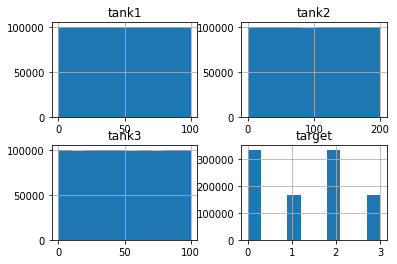

In [13]:
train.hist()
plt.show()

## Validation set

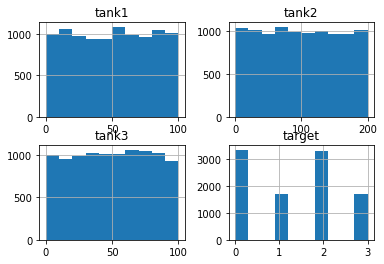

In [14]:
validation.hist()
plt.show()

## Make data ready for classification

In [15]:
y_train = train["target"].values#.reshape((N_TRAIN, ))
X_train = train[["tank1", "tank2","tank3"]].values

y_test = test["target"].values#.reshape((N_TEST, ))
X_test = test[["tank1", "tank2","tank3"]].values

y_val = validation["target"]#.reshape((N_VAL, ))
X_val = validation[["tank1", "tank2","tank3"]].values

In [16]:
X_train = X_train.astype('float32')
X_test = X_test.astype('float32')
X_val = X_val.astype('float32')

# Stochastic gradient descent classifier 

In [17]:
from sklearn.linear_model import SGDClassifier

In [18]:
from sklearn.model_selection import cross_val_predict, cross_val_score
from sklearn.metrics import confusion_matrix

In [19]:
sgd_clf = SGDClassifier(random_state = 42)
sgd_clf.fit(X_train, y_train);

## Cross validation accuracy

In [20]:
CV = 10

In [21]:
cvs = cross_val_score(sgd_clf, X_train, y_train, cv = CV, scoring = "accuracy")
print("Average cross validation score: ", np.mean(cvs))

Average cross validation score:  0.8281550915361864


We now try to see how changes the accuracy when rescaling the data

In [22]:
from sklearn.preprocessing import StandardScaler

In [23]:
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train.astype(np.float64))

In [24]:
cvs = cross_val_score(sgd_clf, X_train_scaled, y_train, cv = CV, scoring = "accuracy")
print("Average cross validation score for scaled train data: ", np.mean(cvs));

Average cross validation score for scaled train data:  0.9425630065789082


In this case accuracy improves when rescaling train data

## Error Analysis

Confusion matrix

In [25]:
y_train_pred = cross_val_predict(sgd_clf, X_train_scaled, y_train, cv = CV)
conf_mx = confusion_matrix(y_train, y_train_pred)
conf_mx

array([[330448,   1990,   1363,      0],
       [  8534, 141598,  10701,   5367],
       [  1495,   1402, 330604,      9],
       [ 10754,   5360,  10462, 139913]])

Note that the squares in the diagonal corresponding to tank 1 and "staying at the depot (3)" are 
slightly darker. This could mean that there are fewer observations of tank 1 and "staying at the depot" being targets or that the classifier does not perform as well on 1,3 as on 0,2 targets.

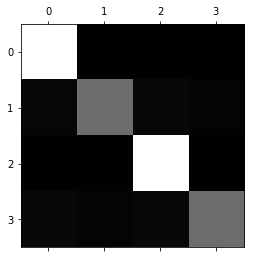

In [26]:
plt.matshow(conf_mx, cmap = plt.cm.gray)
plt.show()

If we look at the errors, we see that there is a tendency to classify observations to class 0 
when they do not correspond to class 0:

In [27]:
row_sums = conf_mx.sum(axis = 1, keepdims = True)
norm_conf_mx = conf_mx / row_sums

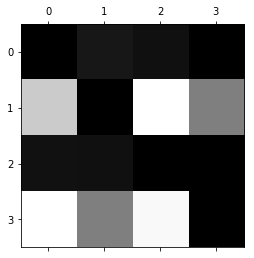

In [28]:
np.fill_diagonal(norm_conf_mx, 0)
plt.matshow(norm_conf_mx, cmap = plt.cm.gray)
plt.show()

## Test prediction accuracy of the model trained on the whole train set

In [29]:
y_test_pred = sgd_clf.predict(X_test)

In [30]:
conf_mx = confusion_matrix(y_test, y_test_pred)
conf_mx

array([[3111,   38,    0,  153],
       [ 162, 1310,   66,  120],
       [ 485,   72, 2558,  225],
       [ 307,   52,   44, 1297]])

In [31]:
test_accuracy = np.trace(np.asarray(conf_mx))/conf_mx.sum()
test_accuracy

0.8276

In [32]:
sgdscaled_clf = SGDClassifier(random_state = 42)
sgdscaled_clf.fit(X_train_scaled, y_train);

scaler = StandardScaler()
X_test_scaled = scaler.fit_transform(X_test.astype(np.float64))

y_test_scaled_pred = sgdscaled_clf.predict(X_test_scaled)
conf_mx = confusion_matrix(y_test, y_test_scaled_pred)
test_accuracy = np.trace(np.asarray(conf_mx))/conf_mx.sum()
test_accuracy

0.9406

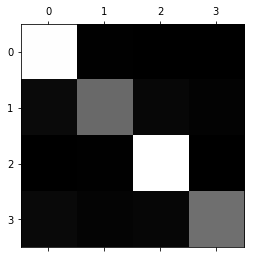

In [33]:
plt.matshow(conf_mx, cmap = plt.cm.gray)
plt.show()

In [34]:
row_sums = conf_mx.sum(axis = 1, keepdims = True)
norm_conf_mx = conf_mx / row_sums

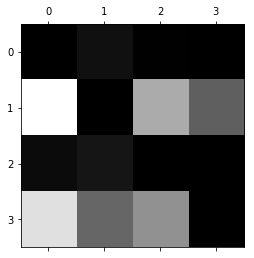

In [35]:
np.fill_diagonal(norm_conf_mx, 0)
plt.matshow(norm_conf_mx, cmap = plt.cm.gray)
plt.show()

# Random forest classifier

In [36]:
from sklearn.ensemble import RandomForestClassifier

rf_clf = RandomForestClassifier(random_state = 42)
rf_clf.fit(X_train, y_train);

## Cross validation accuracy

In [37]:
CV = 10

In [38]:
cvs = cross_val_score(rf_clf, X_train, y_train, cv = CV, scoring = "accuracy")
print("Average cross validation score: ", np.mean(cvs))

Average cross validation score:  0.9983439997499662


In [39]:
from sklearn.preprocessing import StandardScaler

In [40]:
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train.astype(np.float64))

In [41]:
cvs = cross_val_score(rf_clf, X_train_scaled, y_train, cv = CV, scoring = "accuracy")
print("Average cross validation score for scaled train data: ", np.mean(cvs));

Average cross validation score for scaled train data:  0.9983609998699651


The results are the same with scaling and without scaling

## Error Analysis

In [42]:
y_train_pred = cross_val_predict(rf_clf, X_train_scaled, y_train, cv = CV)
conf_mx = confusion_matrix(y_train, y_train_pred)
conf_mx

array([[333469,    109,    223,      0],
       [   255, 165675,    108,    162],
       [   366,    232, 332911,      1],
       [     0,    182,      1, 166306]])

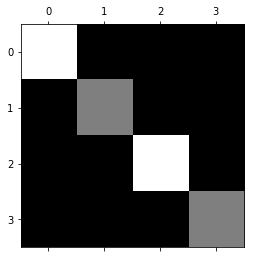

In [43]:
plt.matshow(conf_mx, cmap = plt.cm.gray)
plt.show()

Note that almost all observation are well-classified, so the fact that squares corresponding to tank 1 and
"staying at the depot" are darker just due to the fact that its abundancy is half the abundancy of tanks 0 and 2.

In [44]:
row_sums = conf_mx.sum(axis = 1, keepdims = True)
norm_conf_mx = conf_mx / row_sums

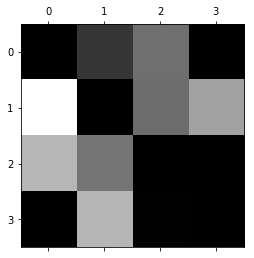

In [45]:
np.fill_diagonal(norm_conf_mx, 0)
plt.matshow(norm_conf_mx, cmap = plt.cm.gray)
plt.show()

## Test prediction accuracy of the model trained on the whole train set

In [46]:
y_test_pred = rf_clf.predict(X_test)

In [47]:
conf_mx = confusion_matrix(y_test, y_test_pred)
conf_mx

array([[3299,    2,    1,    0],
       [   1, 1654,    1,    2],
       [   3,    2, 3335,    0],
       [   0,    2,    0, 1698]])

In [48]:
test_accuracy = np.trace(np.asarray(conf_mx))/conf_mx.sum()
test_accuracy

0.9986

In [49]:
rfscaled_clf = RandomForestClassifier(random_state = 42)
rfscaled_clf.fit(X_train_scaled, y_train);

scaler = StandardScaler()
X_test_scaled = scaler.fit_transform(X_test.astype(np.float64))

y_test_scaled_pred = rfscaled_clf.predict(X_test_scaled)
conf_mx = confusion_matrix(y_test, y_test_scaled_pred)
test_accuracy = np.trace(np.asarray(conf_mx))/conf_mx.sum()
test_accuracy

0.9916

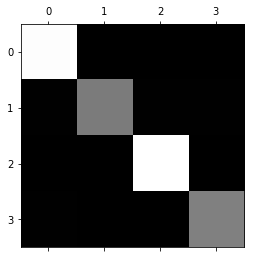

In [50]:
plt.matshow(conf_mx, cmap = plt.cm.gray)
plt.show()

In [51]:
row_sums = conf_mx.sum(axis = 1, keepdims = True)
norm_conf_mx = conf_mx / row_sums

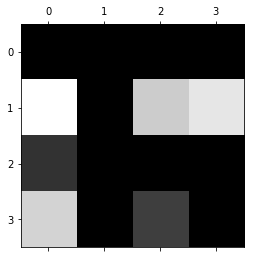

In [52]:
np.fill_diagonal(norm_conf_mx, 0)
plt.matshow(norm_conf_mx, cmap = plt.cm.gray)
plt.show()

# Neural Network Classifier

In [53]:
def reset_graph(seed=42):
    tf.reset_default_graph()
    tf.set_random_seed(seed)
    np.random.seed(seed)


In [54]:
class NNClassifier(object):
    """
    Input to the network is the state, output is the action
    under a deterministic policy.
    """

    def __init__(self, sess, learning_rate, model_file = None):
        self.sess = sess
        self.learning_rate = learning_rate

        # Network architecture
        self.action = self.create_network()
        self.network_params = tf.trainable_variables()
        
    def create_network(self):
       
        with tf.name_scope("dnn"):
            tf.set_random_seed(seed)
            # 1. Parameters to determine the NN architecture

            n_inputs = env.observation_space.shape[1]
            n_hidden1 = 20; activation1 = tf.nn.elu
            n_hidden2 = 6; activation2 = tf.nn.elu
            n_outputs = env.action_space.shape[1]

            self.initializer = tf.contrib.layers.variance_scaling_initializer()

            # 2. Build the Neural Network
            
            self.X = tf.placeholder(tf.float32, shape = (None, n_inputs), name = "X")
            self.y = tf.placeholder(tf.int64, shape = (None), name = "y")
            
            hidden1 = tf.layers.dense(self.X, n_hidden1, activation = activation1,
                                     kernel_initializer = self.initializer)
            hidden2 = tf.layers.dense(hidden1, n_hidden2, activation = activation2,
                                     kernel_initializer = self.initializer)
            logits = tf.layers.dense(hidden2, n_outputs,kernel_initializer = self.initializer)
            
        with tf.name_scope("loss"):
            xentropy = tf.nn.sparse_softmax_cross_entropy_with_logits(labels = self.y,
                                                                      logits = logits)
            loss = tf.reduce_mean(xentropy, name = "loss")
            
        with tf.name_scope("train"):
            # Optimization Op
            optimizer = tf.train.AdamOptimizer(self.learning_rate)
            self.optimize = optimizer.minimize(loss)
            
        with tf.name_scope("eval"):
            correct = tf.nn.in_top_k(logits, self.y, 1)
            self.accuracy = tf.reduce_mean(tf.cast(correct,tf.float32))
      
        with tf.name_scope("action"):
            outputs = tf.nn.softmax(logits)
            # 3. Select a random action (where to go) based on the estimated probabilities
            self.action = tf.multinomial(tf.log(outputs), num_samples = 1)

        self.init = tf.global_variables_initializer()
        
        if model_file != None:
            self.saver = tf.train.Saver()
        
        return self.action#, y, X

    def train(self,X,y):
        self.sess.run(self.optimize, feed_dict={
            self.y: y,
            self.X: X
        })

    def predict_action(self, X, y):
        return self.sess.run(self.action, feed_dict={
            self.X: X,
            self.y: y
        })
    
    def get_accuracy(self, X, y):
        return self.sess.run(self.accuracy, feed_dict={
            self.X: X,
            self.y: y
        })

    def get_num_trainable_vars(self):
        return self.num_trainable_vars
    
    def fetch_batch(self, X,y,epoch, batch_index, batch_size, data_size, n_batches):
        # hands-on book
        #np.random.seed(epoch * n_batches + batch_index)  
        indices = np.random.randint(data_size, size=batch_size)  
        X_batch = X[indices] 
        y_batch = y[indices] 
        return X_batch, y_batch

    def fit(self, X_train, y_train, X_val, y_val, epochs = 10, batch_size = 50, summary_freq = None):
        N_TRAIN = X_train.shape[0]
        m = y_train.shape[0]
        
        n_batches = int(np.ceil(N_TRAIN/ batch_size))
             
        for epoch in range(epochs+1):
            for batch_index in range(n_batches):
                X_batch, y_batch = self.fetch_batch(X_train,y_train,epoch, batch_index, batch_size, m, n_batches)
                self.train(X_batch, y_batch)
            if summary_freq != None:    
                acc_train = self.get_accuracy(X_batch, y_batch)
                acc_val = self.get_accuracy(X_val, y_val)
                if epoch % summary_freq  == 0:
                    print("Epoch: ", epoch, " Train (batch) accuracy: ", acc_train, " Validation accuracy: ", acc_val)


In [55]:
reset_graph()

seed = 43
np.random.seed(seed)

epochs = 250
batch_size = 100

learning_rate = 0.01
summary_freq = np.ceil(epochs/10)


model_file = None#'./final_nn_classifier.ckpt'


with tf.Session() as sess:

                nn_clf = NNClassifier(sess, learning_rate, model_file)
                nn_clf.init.run()
                nn_clf.fit(X_train, y_train, X_val, y_val, epochs = epochs, batch_size = batch_size, summary_freq = summary_freq)
                acc_test = nn_clf.get_accuracy(X_test, y_test)
                acc_train = nn_clf.get_accuracy(X_train, y_train)

                print("All Train accuracy", acc_train, " Test accuracy: ", acc_test)

Instructions for updating:
Use the retry module or similar alternatives.
Epoch:  0  Train (batch) accuracy:  0.96  Validation accuracy:  0.9751
Epoch:  25  Train (batch) accuracy:  1.0  Validation accuracy:  0.9947
Epoch:  50  Train (batch) accuracy:  0.99  Validation accuracy:  0.9935
Epoch:  75  Train (batch) accuracy:  1.0  Validation accuracy:  0.9917
Epoch:  100  Train (batch) accuracy:  1.0  Validation accuracy:  0.9927
Epoch:  125  Train (batch) accuracy:  0.97  Validation accuracy:  0.979
Epoch:  150  Train (batch) accuracy:  1.0  Validation accuracy:  0.992
Epoch:  175  Train (batch) accuracy:  0.99  Validation accuracy:  0.994
Epoch:  200  Train (batch) accuracy:  0.96  Validation accuracy:  0.9812
Epoch:  225  Train (batch) accuracy:  1.0  Validation accuracy:  0.9893
Epoch:  250  Train (batch) accuracy:  1.0  Validation accuracy:  0.9853
All Train accuracy 0.985533  Test accuracy:  0.9865


## Saving and restoring models

In [56]:
reset_graph()

seed = 42
learning_rate = 0.01 #0.01

model_file = './final_nn_classifier_{}.ckpt'.format(learning_rate)
graph_file =  '{}.meta'.format(model_file)
epochs = 2000 #2000
batch_size = 50 #50

summary_freq = 200#np.ceil(epochs/10) #200


hidden1_neurons = 100 #100
hidden2_neurons = 50 #50

scaling = False

if scaling:
    scaler = StandardScaler()
    X_train = scaler.fit_transform(X_train.astype(np.float64))
    X_val = scaler.fit_transform(X_val.astype(np.float64))
    X_test = scaler.fit_transform(X_test.astype(np.float64))
    model_file = './final_nn_classifier_scaled_{}.ckpt'.format(learning_rate)


with tf.name_scope("dnn"):
            tf.set_random_seed(seed)
            # 1. Parameters to determine the NN architecture

            n_inputs = env.observation_space.shape[1]
            n_hidden1 = hidden1_neurons; activation1 = tf.nn.elu
            n_hidden2 = hidden2_neurons; activation2 = tf.nn.elu
            n_outputs = env.action_space.shape[1]

            initializer = tf.contrib.layers.variance_scaling_initializer()

            # 2. Build the Neural Network
            
            X = tf.placeholder(tf.float32, shape = (None, n_inputs), name = "X")
            y = tf.placeholder(tf.int64, shape = (None), name = "y")
            
            hidden1 = tf.layers.dense(X, n_hidden1, activation = activation1,
                                     kernel_initializer = initializer)
            hidden2 = tf.layers.dense(hidden1, n_hidden2, activation = activation2,
                                     kernel_initializer = initializer)
            logits = tf.layers.dense(hidden2, n_outputs,kernel_initializer = initializer)
            
with tf.name_scope("loss"):
            xentropy = tf.nn.sparse_softmax_cross_entropy_with_logits(labels = y,
                                                                      logits = logits)
            loss = tf.reduce_mean(xentropy, name = "loss")
            
with tf.name_scope("train"):
            # Optimization Op
            optimizer = tf.train.AdamOptimizer(learning_rate)
            optimize = optimizer.minimize(loss)
            
with tf.name_scope("eval"):
            correct = tf.nn.in_top_k(logits, y, 1)
            accuracy = tf.reduce_mean(tf.cast(correct,tf.float32))
            
with tf.name_scope("action"):
            outputs = tf.nn.softmax(logits)
            # 3. Select a random action (where to go) based on the estimated probabilities
            action = tf.multinomial(tf.log(outputs), num_samples = 1)

init = tf.global_variables_initializer()
        
if model_file != None:
            saver = tf.train.Saver()
        

def fetch_batch(X,y,epoch, batch_index, batch_size, data_size, n_batches):
        #np.random.seed(epoch * n_batches + batch_index)  
        indices = np.random.randint(data_size, size=batch_size)  
        X_batch = X[indices] 
        y_batch = y[indices] 
        return X_batch, y_batch
    
    
best_acc_val = 0
acc_val = 0
# early_stopping = True
# stopping_counter = 0
# max_stopping_counter = 100

with tf.Session() as sess:
        init.run()
        N_TRAIN = X_train.shape[0]
        m = y_train.shape[0]
        
        n_batches = int(np.ceil(N_TRAIN/ batch_size))
             
        for epoch in range(epochs+1):
            print("\rEpoch: {}".format(epoch), end="")
            for batch_index in range(n_batches):
                X_batch, y_batch = fetch_batch(X_train,y_train,epoch, batch_index, batch_size, m, n_batches)
                #print("Xbatch shape",X_batch.shape, "y_batch shape", y_batch.shape)
                sess.run(optimize, feed_dict={
                                    y: y_batch,
                                    X: X_batch
                                })
    
            if summary_freq != None: 
                            
                if epoch % summary_freq  == 0:
                    

                    acc_train = sess.run(accuracy, feed_dict={
                                        y: y_batch,
                                        X: X_batch
                                    })
                    acc_val = sess.run(accuracy, feed_dict={
                                        y: y_val,
                                        X: X_val
                                    }) 
                                    
                    
                    best_acc_val = max(best_acc_val, acc_val)

                    print(". Train (batch) accuracy: ", acc_train, 
                          " Validation accuracy: ", acc_val)
                    if best_acc_val <= acc_val:                        
                        save_path = saver.save(sess, model_file)
                        print("Saved model with validation accuracy ", acc_val)
                                     
        #save_path = saver.save(sess, model_file)   

Epoch: 0. Train (batch) accuracy:  1.0  Validation accuracy:  0.9654
Saved model with validation accuracy  0.9654
Epoch: 107

KeyboardInterrupt: 

In [ ]:
with tf.Session() as sess: 
    saver.restore(sess, model_file)
    acc_test = sess.run(accuracy, feed_dict={
                                    y: y_test,
                                    X: X_test
                               })
    print(" Test accuracy of the best model saved (according to validation accuracy): ", acc_test)
    
    

## Adding summaries to visualize performance metrics with TensorBoard

In [ ]:
reset_graph()

seed = 42
learning_rate = 0.01 #0.01

model_file = './final_nn_classifier_{}.ckpt'.format(learning_rate)
graph_file =  '{}.meta'.format(model_file)
epochs = 2000 #2000
batch_size = 50 #50

summary_freq = 100#np.ceil(epochs/10) #200


hidden1_neurons = 100 #100
hidden2_neurons = 50 #50

scaling = False

if scaling:
    scaler = StandardScaler()
    X_train = scaler.fit_transform(X_train.astype(np.float64))
    X_val = scaler.fit_transform(X_val.astype(np.float64))
    X_test = scaler.fit_transform(X_test.astype(np.float64))
    model_file = './final_nn_classifier_scaled_{}.ckpt'.format(learning_rate)

with tf.name_scope("dnn"):
            tf.set_random_seed(seed)
            # 1. Parameters to determine the NN architecture

            n_inputs = env.observation_space.shape[1]
            n_hidden1 = hidden1_neurons; activation1 = tf.nn.elu
            n_hidden2 = hidden2_neurons; activation2 = tf.nn.elu
            n_outputs = env.action_space.shape[1]

            initializer = tf.contrib.layers.variance_scaling_initializer()

            # 2. Build the Neural Network
            
            X = tf.placeholder(tf.float32, shape = (None, n_inputs), name = "X")
            y = tf.placeholder(tf.int64, shape = (None), name = "y")
            
            hidden1 = tf.layers.dense(X, n_hidden1, activation = activation1,
                                     kernel_initializer = initializer)
            hidden2 = tf.layers.dense(hidden1, n_hidden2, activation = activation2,
                                     kernel_initializer = initializer)
            logits = tf.layers.dense(hidden2, n_outputs,kernel_initializer = initializer)
            
with tf.name_scope("loss"):
            
            xentropy = tf.nn.sparse_softmax_cross_entropy_with_logits(labels = y,
                                                                      logits = logits)
            loss = tf.reduce_mean(xentropy, name = "loss")
            
tf.summary.scalar('average_cross_entropy', loss)
            
with tf.name_scope("train"):
            # Optimization Op
            optimizer = tf.train.AdamOptimizer(learning_rate)
            optimize = optimizer.minimize(loss)
            
with tf.name_scope("eval"):
            correct = tf.nn.in_top_k(logits, y, 1)
            accuracy = tf.reduce_mean(tf.cast(correct,tf.float32))
tf.summary.scalar('accuracy', accuracy)

            
with tf.name_scope("action"):
            outputs = tf.nn.softmax(logits)
            # 3. Select a random action (where to go) based on the estimated probabilities
            action = tf.multinomial(tf.log(outputs), num_samples = 1)

merged = tf.summary.merge_all()
init = tf.global_variables_initializer()
        
if model_file != None:
            saver = tf.train.Saver()
        

def fetch_batch(X,y,epoch, batch_index, batch_size, data_size, n_batches):
        #np.random.seed(epoch * n_batches + batch_index)  
        indices = np.random.randint(data_size, size=batch_size)  
        X_batch = X[indices] 
        y_batch = y[indices] 
        return X_batch, y_batch
    
    
best_acc_val = 0
acc_val = 0

now = datetime.utcnow().strftime("%Y%m%d%H%M%S")
root_logdir = "tf_logs"
log_dir = "{}/run-{}/".format(root_logdir, now)

with tf.Session() as sess:
        train_writer = tf.summary.FileWriter(log_dir + '/train', sess.graph)
        val_writer = tf.summary.FileWriter(log_dir + '/val')
        
        init.run()
        N_TRAIN = X_train.shape[0]
        m = y_train.shape[0]
        
        n_batches = int(np.ceil(N_TRAIN/ batch_size))
        #print(n_batches)
             
        for epoch in range(epochs+1):
            print("\rEpoch: {}".format(epoch), end="")            
            for batch_index in range(n_batches):
                X_batch, y_batch = fetch_batch(X_train,y_train,epoch, batch_index, batch_size, m, n_batches)
                #print("Xbatch shape",X_batch.shape, "y_batch shape", y_batch.shape)
                sess.run(optimize, feed_dict={
                                    y: y_batch,
                                    X: X_batch
                                })
    
            if summary_freq != None: 
                            
                if epoch % summary_freq  == 0:
                    

                    summary, acc_train = sess.run([merged, accuracy], feed_dict={
                                        y: y_batch,
                                        X: X_batch
                                    })
                    train_writer.add_summary(summary, epoch)

                    summary, acc_val = sess.run([merged, accuracy], feed_dict={
                                        y: y_val,
                                        X: X_val
                                    }) 
                                    
                    val_writer.add_summary(summary, epoch)

                    best_acc_val = max(best_acc_val, acc_val)

                    print(". Train (batch) accuracy: ", acc_train, 
                          " Validation accuracy: ", acc_val)
                    if best_acc_val <= acc_val:                        
                        save_path = saver.save(sess, model_file)
                        print("Saved model with validation accuracy ", acc_val)
        train_writer.close()
        val_writer.close()                            
        #save_path = saver.save(sess, model_file)   

In [ ]:
with tf.Session() as sess: 
    saver.restore(sess, model_file)
    acc_test = sess.run(accuracy, feed_dict={
                                    y: y_test,
                                    X: X_test
                               })
    print(" Test accuracy of the best model saved (according to validation accuracy): ", acc_test)

## "Playing" the product delivery game with the learnt policy

In [59]:
episode_length = 30
seed = 80

system = PDSystemEnv(tank_max_loads = TANK_MAX_LOADS, level_percentages = LEVEL_PERCENTAGES,
                     truck_max_loads = TRUCK_MAX_LOADS, graph_weights = GRAPH_WEIGHTS,  
                     discrete = DISCRETE)
# ENSURE TO SET CASE = -1 (or another negative number) in the pdsystem_env.py
env = gym.make("PDSystemEnv-v0")
env._max_episode_steps = episode_length

test  = True

In [60]:
frames = []
n_episodes = 10

with tf.Session() as sess:
        sess.run(init)
        saver.restore(sess, model_file)
        for episode in range(n_episodes):
            state = env.reset()
            for step in range(episode_length):
                system.state = state
                img = system.visualize()
                frames.append(img)

                action_val = action.eval(feed_dict={X: state.reshape(1, n_inputs)})
 
                state, reward, done, info = env.step(action_val[0])
                #print(action_val[0],emptiest_tank_policy(state, system))
        
                if done:
                    break
        env.close()
    

INFO:tensorflow:Restoring parameters from ./final_nn_classifier_0.01.ckpt


In [61]:
test_anim = ut.create_system_animation(frames, n_episodes * episode_length)
plt.close()

HTML(test_anim.to_html5_video())

## Testing the trained model on extreme (hand-crafted) observations

Coming soon...

* See if when two plants are empty the model is able to predict well the left most empty tank.
  if not, try to train the model with data that has this situations. And if the problem persists,
  try to use the sigmoid function as activation function, since it is not zero when the input is zero.